In [1]:
# Leon Gaillard

&copy; Heliocity 2020

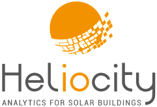

# Tutorial 4Sun: first steps to photovoltaic performance analysis
## Introduction

This tutorial is intended to be preliminary introduction to monitoring building-integrated photovoltaic (**BIPV**) installations
Monitoring using python. Questions to be answered in this tutorial:

1. How can I present PV monitoring data and combine weather data sources using python?
2. What performance measures are used for the analysis of PV systems?
3. What does the performance of a typical BIPV system look like?


*__Pre-requisites:__* 
* *The reader is assumed to understand the general arrangement of a grid-tied photovoltaic technology.* 
* *This tutorial used the python programming language. Readers who do not have prior knowledge of python should focus on the data insights. Python users can utilise the code here to achieve similar things in their analyses!*

In [2]:
# python configuration
import pandas as pd
from pandas.tseries.frequencies import to_offset
import matplotlib.pyplot as plt
import os
%matplotlib inline
datapath = "./DAT"

## BIPV monitoring data

Today, many BIPV installations are equiped with some form of remote data monitoring system, albeit with a wide range of data quality, spatial and temporal resolution. Overall there are two common types of monitoring system:

1. Web-connected power conditionners: string inverters (eg. SMA), micro-inverters (eg. Enphase), DC-optimisers (eg. SolarEdge)
2. Dedicated SCADA systems: PV monitoring services (eg. MeteoControl, QoS), or bespoke instrumentation

For the purpose of this tutorial, we’re going to use some data from a well-instrumented research bench at INES, illustrated in the photo below.


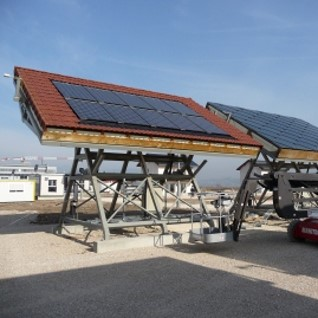

### Hourly monitoring data
Let's look at the monitoring data for a month. The following opertions import data from Excel into the native format of the python package for data analysis Pandas. The object "dataset" is a Pandas DataFrame, which is R-style indexed table. By default the index is the first column of the Excel file. As we are using timeseries data, it is useful to apply index of timestamps (or datetimeindex using the Pandas definition). To do this we combine date and time columns into a single datetime column, and then set this as the index of the DataFrame. 

In [3]:
datafile = "data_hourly_bipv_2011-05-01_2011-05-31.xlsx"
dataset = pd.read_excel(io=os.path.join(datapath, datafile), sheet_name="dataset", header=0, index_col=0)
dataset['date'] = pd.to_datetime(dataset.index.astype(str) + ' ' + dataset['time'].astype(str), format="%Y/%m/%d %H:%M:%S")
dataset = dataset.set_index('date')

Derived variables can be added to the list of columns

In [4]:
dataset['Pdc'] = dataset['_Ielec DC avg [A]']*dataset['_Uelec DC avg [V]']

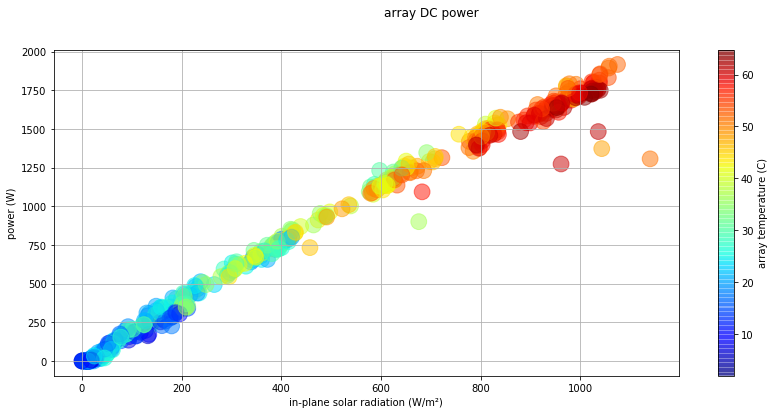

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6), facecolor='w')
fig.canvas.set_window_title("scatter plot")
plt.scatter(dataset['_Gi avg [W/m2]'], dataset['Pdc'], s=250,c=dataset['Tpv mean'],cmap='jet',alpha=0.5)
plt.suptitle("array DC power")
plt.grid()
plt.xlabel("in-plane solar radiation (W/m²)")
plt.ylabel("power (W)")
cb = plt.colorbar()
cb.set_label("array temperature (C)")


* To first order, DC power is proportional to total in-plane solar radiation
* Array temperature is also strongly correlated to incident radiation and power 
* Some outliers are also clearly visible, in general periods of low power relative to incident radiation (below the trend)

**Question for the student**: what are the possible causes for the outliers?

## Satellite weather data
Unlike the INES dataset used in this tutorial, most BIPV installation are not equiped with on-site weather stations. For such a case, it is possible to substitute with data from weather satellites. Historical weather data is publically available, and depending on the requirements of an analysis, can be entirely free to use. For example, as this tutorial was written in France, let's use the Merra2 dataset made available via the SODA Pro service: 

http://www.soda-pro.com/web-services/meteo-data/merra

*The Modern-Era Retrospective analysis for Research and Applications, Version 2 (MERRA-2) Web service, available worldwide, delivers time series of Temperature (at 2 m), Relative Humidity (at 2 m), Pressure (at 2 m), Wind speed and direction (at 10 m), Rainfall, Snowfall and Snow depth.*

*Time steps range from 1 min up to 1 month (original data are hourly). Spatial resolution of approx. 50 km. The data are available since Jan. 1980 and are regularly updated with approx. one month of delay.*

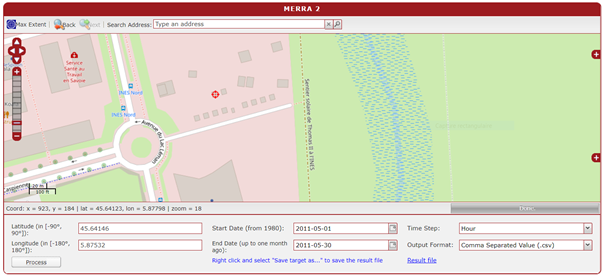

In [6]:
meteofile = "SoDa_MERRA2_lat45.641_lon5.875_2011-05-01_2011-05-30_1400773339.csv"
meteoset = pd.read_csv(filepath_or_buffer=os.path.join(datapath, meteofile), sep=";", index_col=0, header=22)

As for the PV monitoring data, we will set a datetime index using the date and time columns. Note that here we have to appy a small format correction first, to handle datapoints at midnight

In [7]:
meteoset['date'] = pd.to_datetime(meteoset.index.astype(str), format="%Y/%m/%d") # set date format to datetime
meteoset.loc[meteoset['UT time'] == '24:00','date'] += pd.DateOffset(days=1)  # increment date by 1 day for midnight
meteoset.loc[meteoset['UT time'] == '24:00','UT time'] = '00:00'  # replace midnight value by 00:00

# set new date time index using corrected dates and times
meteoset['date'] = pd.to_datetime(meteoset['date'].astype(str) + ' ' + meteoset['UT time'].astype(str), format="%Y/%m/%d %H:%M:%S")
meteoset = meteoset.set_index('date')

# unit conversion
meteoset['Temperature'] -= 273.15  # convert K to C

Text(0, 0.5, 'Temperature (C)')

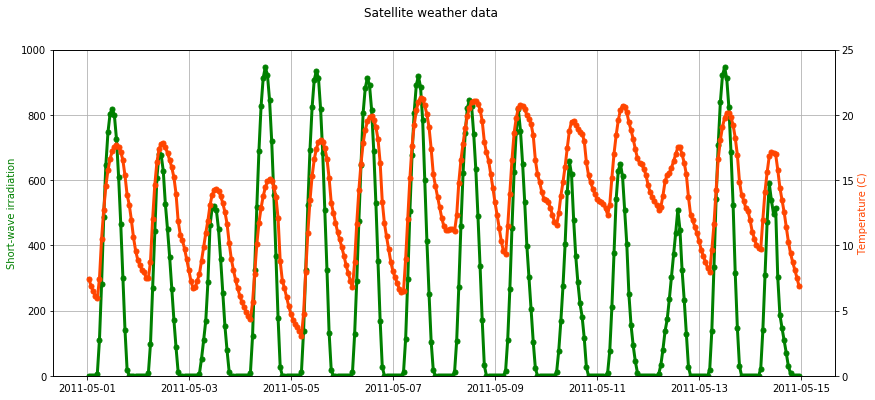

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6), facecolor='w')
plt.suptitle("Satellite weather data")
plt.plot(meteoset['2011-05-01':'2011-05-14'].filter(["Short-wave irradiation"]), linewidth=3, marker='.', color='green', markersize=10, linestyle='-')
plt.ylabel("Short-wave irradiation", color='green')
plt.ylim(0,1000)
plt.grid()

ax2 = ax.twinx()
plt.sca(ax2)
plt.plot(meteoset['2011-05-01':'2011-05-14'].filter(["Temperature"]), linewidth=3, marker='.', color='orangered', markersize=10, linestyle='-')
plt.ylim(0,25)
plt.ylabel("Temperature (C)",color='orangered')


As we have prepared the PV dataset and meteo dataset both with datetime indexes (on the same time base), we can simply concatenate the two DataFrames

In [9]:
dataset = pd.concat([dataset,meteoset],axis=1)  # overwrite dataset by the concatenated table

### Side note on timebase and aggregation over time steps
The above meteo data are hourly values. It is important to understand the timebase of such sources, especially when combining with other data, and when aggregating over time intervals. To illustrate this, we'll import a small sample of minute-wise data and aggregate to mean hourly values

In [10]:
datafile = "minutewise_bipv_2011-05-5_2011-05-6.xlsx"
dataday = pd.read_excel(io=os.path.join(datapath, datafile), sheet_name="dataset", header=0, index_col=0)
dataday['date'] = pd.to_datetime(dataday.index, format="%Y/%m/%d %H:%M:%S")
dataday = dataday.set_index('date')

To aggregate the minutewise data to hourly values, we can used the DataFrame member function **groupby()** using a column of time interval labels. To create this column, we can define a custom function to derive the intervals from the datetime index

In [11]:
def dtwin(x,dt):
    """
    row-wise dataframe.apply operation to determine time interval values based on a datetime column
    :param x: variable required by dataframe.apply. Value of specified column
    :param dt: timedelta defining interval. See append_dtwin
    :return: time of current bin rounded by interval
    """
    trnd = x.round(dt)
    if x < trnd+(dt/2.0):
        return trnd
    else:
        return trnd+dt


In the following operations, we shift the timebase by 30 minutes to centre time windows around the hour, and then calculate the time interval labels and aggregate the data.

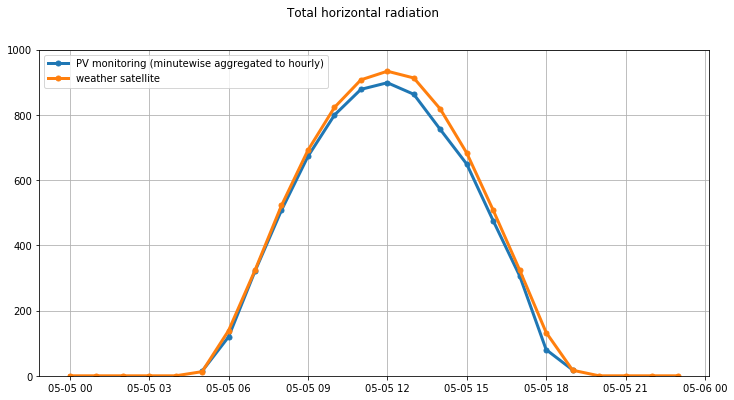

In [12]:
# append a column to df containing time intervals
dataday['tabs'] = dataday.index

#-------------------------------------------------------------------------------------------#
"""comment out this line to see the impact of failing to apply comparable time windows"""
dataday['tabs'] = dataday['tabs'] - pd.DateOffset(hours=0.5)  
#-------------------------------------------------------------------------------------------#

# generate the column of time interval labels
dataday['dt 1h'] = dataday['tabs'].apply(dtwin, args=(pd.to_timedelta(to_offset('1h')),))

# aggregate the data to the hourly basis using the time intervals and combine with weather data
dataday_hourly = dataday.groupby('dt 1h').mean()  # arithmetic mean of all columns per interval
datasubset = pd.concat([dataday_hourly,meteoset['2011-05-05']],axis=1)

# display the result
fig, ax = plt.subplots(1, 1, figsize=(12, 6), facecolor='w')
plt.plot(datasubset.filter(["_Gh avg [W/m2]","Short-wave irradiation"]), linewidth=3, marker='.', markersize=10, linestyle='-')
plt.suptitle("Total horizontal radiation")
plt.legend(["PV monitoring (minutewise aggregated to hourly)","weather satellite"])
plt.ylim(0,1000)
plt.grid()


The hourly-centred values align with the measurements of total horizontal radiation provided by the satellite data source. Extrapolating over a longer period, the following figure presents hourly local and satellite horizontal radiation measurements spanning several days.

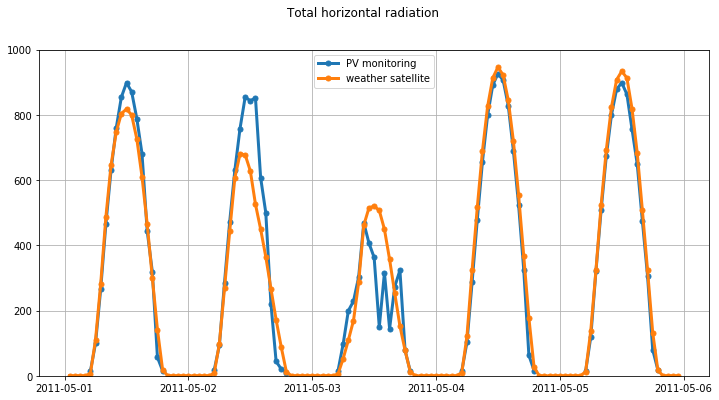

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), facecolor='w')
plt.plot(dataset['2011-05-01':'2011-05-05'].filter(["_Gh avg [W/m2]","Short-wave irradiation"]), linewidth=3, marker='.', markersize=10, linestyle='-')
plt.suptitle("Total horizontal radiation")
plt.legend(["PV monitoring","weather satellite"])
plt.ylim(0,1000)
plt.grid()


### Discussion
As can be seen in the above figure, the use of satellite weather data for the estimation of local radiation conditions can introduce significant uncertainties in performance evaluation. 

Note that differences between remote and local radiation measurements arise due differences in
* spatial resolution (point measurement vs. kilometre pixel)
* sensor technology (pyranometre vs. imaging)
* calculations and simplifying assumptions (absolute measurement vs. interpreted values)

These discrepancies are even more pronounced for estimations of in-plane radiation due to the effect of ground and neighbouring structures. Satellite data remain highly useful, providing they can be used appropriately and if necessary, corrected for the local environment, depending on the desired accuracy of performance evaluation.

The method to correct these differences lies outside the scope of the current tutorial. In the following discussion of BIPV performance we will use onsite weather data. 

## Analysis of integrated BIPV performance 

Rather than considering instantaneous power output, the performance of PV installations is typically evaluated using integrated measures energy generation. To introduce these performance measures, we will first aggregate the hourly monitoring dataset and obtain of sum each quantity per interval. For illustration we will consider daily values, but the principle is identical for weekly, monthly or annual intervals. The aggregation method is essentially the same as above:

In [14]:
dataset['doy'] = dataset.index.dayofyear  # time interval column
total_daily = dataset.groupby('doy').sum()  # aggregated daily sums

# replace day-of-year index by dates
start_date = '2011-05-01'  # dataset.index.min()
end_date = '2011-05-31'  # dataset.index.max()
total_daily['date'] = pd.date_range(start=start_date,end=end_date,freq='1D')
total_daily = total_daily.set_index('date')

### Performance measures
The international standard **IEC 61724 "Photovoltaic system performance monitoring –** _**Guidelines for measurement, data exchange and analysis"**_ introduces several performance measures, and in particular, **normalised performance measures that are useful for the comparison of PV installations**. The standard generalises PV systems by the following schema (coloured zones relevant to current discussion), and provides measures for each component, from the array (DC side), to grid injection (AC side), whilst taking environmental conditions into account.

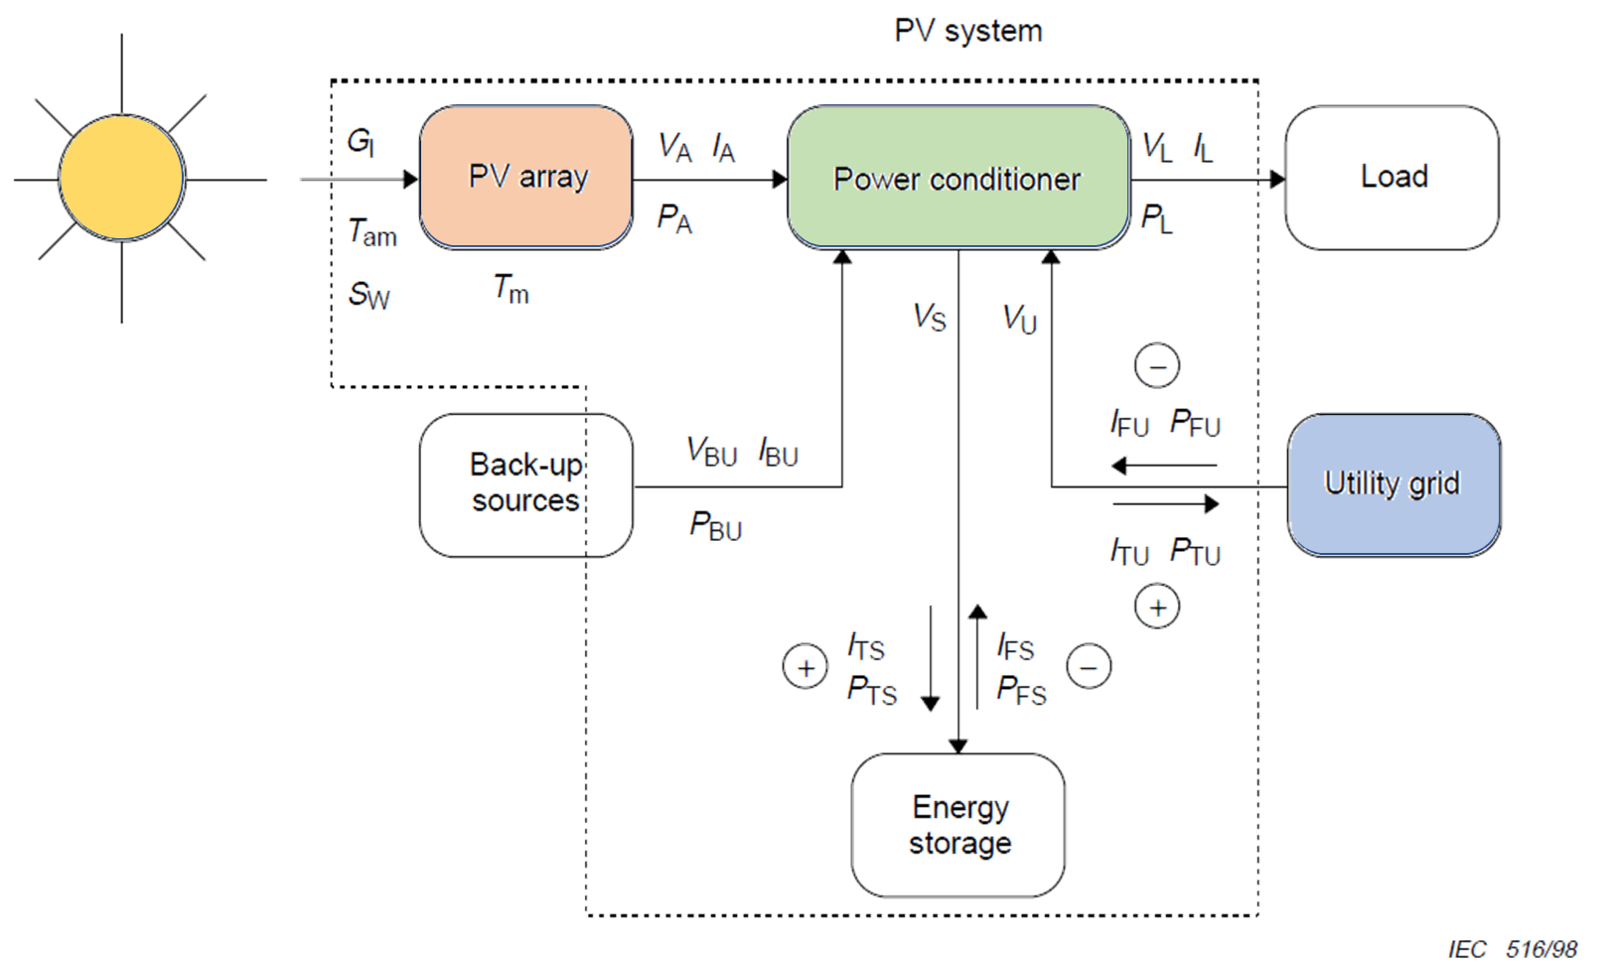

The following normalised measures are interesting to evaluate system performance. According to the standard, _"Yields are energy quantities normalised to rated array power. System efficiencies are normalised to array area. Losses are the differences between yields."_ The following text is an extract of the standard:

>a) The array yield YA is the daily array energy output per kW of installed PV array:
>
> YA = EA,d / P0 = tr ´ (Sday PA) / P0 (13)
>
> The symbol Sday denotes the summation for the day. This yield represents the number of
hours per day that the array would need to operate at its rated output power P0 to
contribute the same daily array energy to the system as was monitored (which equals
tr ´ (Sday PA)).
>
>b) The final PV system yield Yf is the portion of the daily net energy output of the entire PV
plant which was supplied by the array per kW of installed PV array:
>
>Yf = YA ´ hLOAD (14)
>
>This yield represents the number of hours per day that the array would need to operate at
its rated output power P0 to equal its monitored contribution to the net daily load.
>
>c) The reference yield Yr can be calculated by dividing the total daily in-plane irradiation by the
module's reference in-plane irradiance GI,ref (kW×m–2):
>
>Yr = tr ´ (Sday GI) / GI, ref (15)
>
>This yield represents the number of hours per day during which the solar radiation would
need to be at reference irradiance levels in order to contribute the same incident energy as
was monitored. If GI,ref = 1 kW×m–2, then the in-plane irradiation in units of kWh×m–2×d–1 is
numerically equal to a corresponding nominal array energy output in units of kWh×d–1×kW–1.
Thus Yr would be, in effect, the number of peak sun-hours per day (h×d–1).


These performance measures are easily calcualted for the current dataset via the following operations

In [15]:
#calculate ref yield
Pmax = 2142
total_daily['PM YRef'] = total_daily['_Gi avg [W/m2]']/1000
total_daily['PM YArray'] = total_daily['Pdc']/Pmax
total_daily['PM YFinal'] = total_daily['_Pelec AC avg [W]']/Pmax

Furthermore, the follinwg derived performance measaures are defined by IEC 61724

>Normalized losses are calculated by subtracting yields. Losses also have units of kWh×d–1×kW–1
(or h×d–1) and indicate the amount of time during which the array would be required to operate
at its rated power P0 to provide for the losses.
>
>a) The "array capture" losses Lc represents the losses due to array operation:
>Lc = Yr – YA
>
>b) The BOS losses LBOS represents the losses in the BOS components:
>LBOS = YA ´ (1 – hBOS)
>
>c) The performance ratio RP indicates the overall effect of losses on the array's rated output
due to array temperature, incomplete utilisation of the irradiation, and system component
inefficiencies or failures:
>RP = Yf / Yr

The performance ratio is particularly useful, because it provides an assessment of system performance normalised to incident radiation. By definition, PR = 100% corresponds to an installation operating at its equivalent rated power under reference conditions of 1000 W/m² incident radiation and an array temperature of 25°C. Manufacturer datasheet values are quoted at these conditions. In general a performance ratio of >90% indicates a PV installation in excellent condition. 

In [16]:
total_daily['PM Lc'] = total_daily['PM YRef'] - total_daily['PM YArray']
total_daily['PM Lbos'] = total_daily['PM YArray'] - total_daily['PM YFinal']
total_daily['PM PerfRatio'] = total_daily['PM YFinal']/total_daily['PM YRef']*100

Text(0, 0.5, 'Performance ratio (%)')

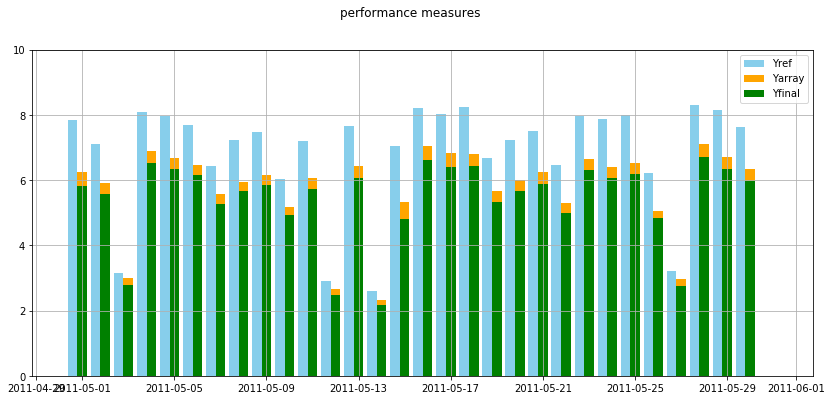

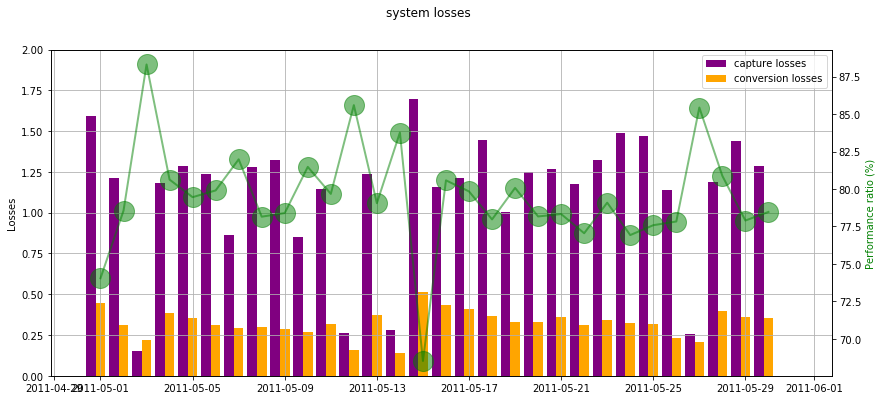

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6), facecolor='w')
fig.canvas.set_window_title("performance measures")
plt.bar(x=total_daily.index+pd.DateOffset(hours=-10),height=total_daily['PM YRef'], width=0.4167, color='skyblue')
plt.bar(x=total_daily.index,height=total_daily['PM YArray'], width=0.4167, color='orange')
plt.bar(x=total_daily.index,height=total_daily['PM YFinal'], width=0.4167, color='green')
plt.suptitle("performance measures")
plt.legend(["Yref","Yarray","Yfinal"])
plt.ylim(0,10)
plt.grid()

fig, ax = plt.subplots(1, 1, figsize=(14, 6), facecolor='w')
fig.canvas.set_window_title("performance measures")
plt.bar(x=total_daily.index+pd.DateOffset(hours=-10),height=total_daily['PM Lc'], width=0.4167, color='purple')
plt.bar(x=total_daily.index,height=total_daily['PM Lbos'], width=0.4167, color='orange')
plt.suptitle("system losses")
plt.legend(["capture losses","conversion losses"])
plt.ylim(0,2)
plt.grid()
plt.ylabel("Losses")

ax2 = ax.twinx()
plt.sca(ax2)
plt.plot(total_daily.filter(['PM PerfRatio']), color='green', linewidth=2, marker='o', markersize=20, linestyle='-', alpha=0.5)
plt.ylabel("Performance ratio (%)",color='green')

The above display illustrates that both losses increase with incident radiation (reference yield), although they are impacted by different factors. The daily performance ratio is seen to vary around ~80%, which represents an under-performance that demands explanation.

To understand better, we can consider the performance ratio as a function of its constituent yields and the associated losses.

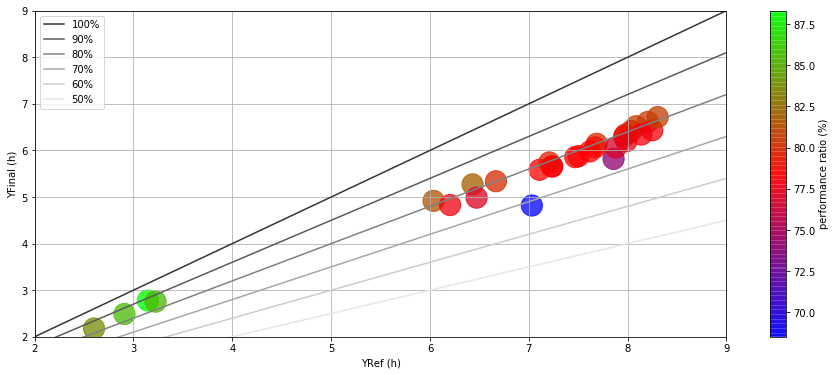

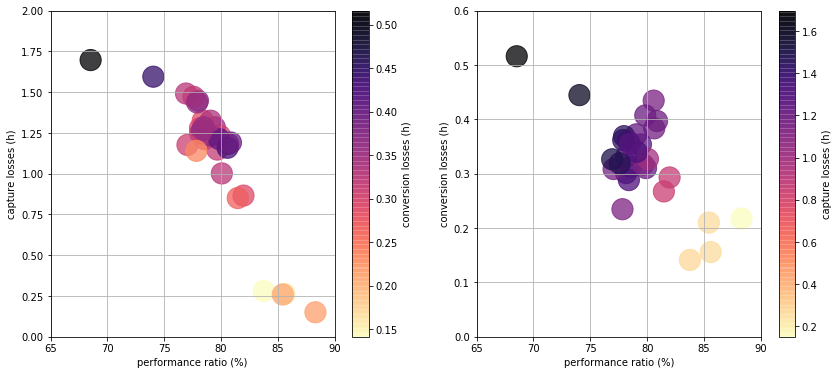

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15.5, 6), facecolor='w')
fig.canvas.set_window_title("Performance ratio")
YR=[0,2,4,6,8,10]
plt.plot(YR,YR,color='0.20')  # PR=100
plt.plot(YR,[x*0.9 for x in YR],color='0.35')  # PR=90
plt.plot(YR,[x*0.8 for x in YR],color='0.50')  # PR=80
plt.plot(YR,[x*0.7 for x in YR],color='0.65')  # PR=70
plt.plot(YR,[x*0.6 for x in YR],color='0.80')  # PR=60
plt.plot(YR,[x*0.5 for x in YR],color='0.90')  # PR=50
plt.legend(["100%","90%","80%","70%","60%","50%"])
plt.scatter(total_daily['PM YRef'], total_daily['PM YFinal'], s=450,c=total_daily['PM PerfRatio'],cmap='brg',alpha=0.75)
plt.xlim(2,9)
plt.ylim(2,9)
plt.xlabel('YRef (h)')
plt.ylabel('YFinal (h)')
cb = plt.colorbar()
cb.set_label("performance ratio (%)")
plt.grid()

fig, ax = plt.subplots(1, 2, figsize=(14, 6), facecolor='w')
fig.canvas.set_window_title("Performance ratio")
plt.sca(ax[0])
plt.scatter(total_daily['PM PerfRatio'], total_daily['PM Lc'], s=450, c=total_daily['PM Lbos'],cmap='magma_r',alpha=0.75)
plt.xlim(65,90)
plt.ylim(0,2)
plt.xlabel('performance ratio (%)')
plt.ylabel('capture losses (h)')
cb = plt.colorbar()
cb.set_label("conversion losses (h)")
plt.grid()
plt.sca(ax[1])
plt.scatter(total_daily['PM PerfRatio'], total_daily['PM Lbos'], s=450, c=total_daily['PM Lc'],cmap='magma_r',alpha=0.75)
plt.xlim(65,90)
plt.ylim(0,0.6)
plt.xlabel('performance ratio (%)')
plt.ylabel('conversion losses (h)')
cb = plt.colorbar()
cb.set_label("capture losses (h)")
plt.grid()



We observe that under sunny conditions, the performance ratio of the BIPV test bench is around 80%. Under cloudy conditions, the BIPV test bench tends to higher values, up to ~87%. Outliers with low performance are also visible, where PR<75%. In general, low values of PR are explained in particular by high capture losses. A more loose relationship is observed with conversion losses.

**Question for the student**: what is the likely cause low performance for the worst day?

## BIPV temperature and system performance
The major cause for a decreasing performance ratio towards high solar radiation is a negative temperature coefficient for crystaline Silicon cells. Typically, for each 1°C increase in module temperature, the maximum power point of a PV module decreases by 0.5% of its rated power. Hence, ignoring all other losses a performance ratio of 80% can be interpreted as an operating temperature of 65°C.

PV manufacturers report the expected operting temperature of their modules on their product datasheets. The Nominal Operating Cell Temperature (NOCT) is defined as the temperature a well-ventilated PV module should attain under steady conditions of incident radiation, ambient temperature and wind speed of 800 W/m², 20°C and 1 m/s respectively. The rating corresponds to a linear model for module temperature.

Let's define a function with which to calculate the temperature using the NOCT model. The function will be used in the same manner as the time interval label function above.

In [19]:
#calculate Tnoct
def TpvNOCT(row,cols,pars):
    """photovoltaic array temperature assuming linear NOCT model"""
    Ta = row[cols[0]]
    Gi = row[cols[1]]
    Vv = row[cols[2]]
    TcNOCT = pars[0]
    etapv = pars[1]
    TaNOCT = 20
    GiNOCT = 800
    taualpha = 0.9
    Gmod = Gi/GiNOCT
    Tmod = TcNOCT - TaNOCT
    Vmod = 9.5/(5.7+(3.8*Vv))
    Pmod = 1-(etapv/taualpha)
    Tc = Ta + (Gmod*Tmod*Vmod*Pmod)
    return Tc

variables = ['_Tex avg [C]', '_Gi avg [W/m2]', '_Vv avg [m/s]']
params = [50, 0.126]
dataset['NOCT [C]'] = dataset.apply(TpvNOCT, args=(variables,params), axis=1)

#compare maximum NOCT temerpature to measured module temperature
print("maximum NOCT temperature = {0:0.2f} C".format(dataset['NOCT [C]'].max()),
      "maximum measured array temperature = {0:0.2f} C".format(dataset['Tpv mean'].max()))

maximum NOCT temperature = 49.28 C maximum measured array temperature = 64.80 C


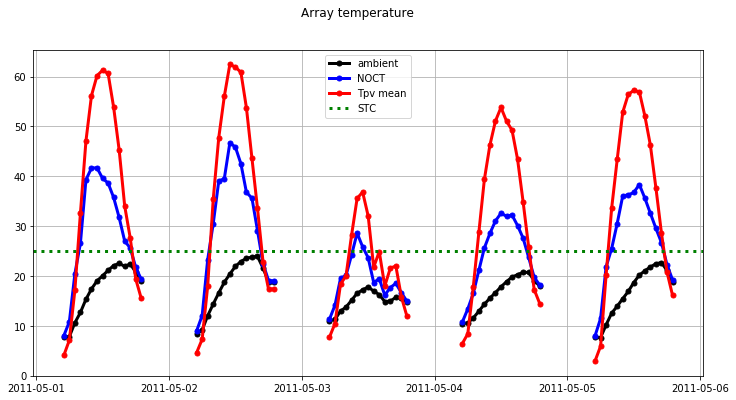

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), facecolor='w')
fig.canvas.set_window_title("scatter plot")
plt.plot(dataset['2011-05-01':'2011-05-05'].filter(['_Tex avg [C]']), color='black', linewidth=3, marker='.', markersize=10, linestyle='-')
plt.plot(dataset['2011-05-01':'2011-05-05'].filter(['NOCT [C]']), color='blue', linewidth=3, marker='.', markersize=10, linestyle='-')
plt.plot(dataset['2011-05-01':'2011-05-05'].filter(['Tpv mean']), color='red', linewidth=3, marker='.', markersize=10, linestyle='-')
plt.grid()
ax.axhline(25,color='green',linestyle=":",linewidth=3)
plt.suptitle("Array temperature")
plt.legend(["ambient","NOCT","Tpv mean","STC"])

We see that the measured array temperature significantly exceeds the NOCT according to the module manufacturer during the middle of the day. For the month of May, the expected peak array temperature assuming the NOCT model is 49.28 C. Measurements for the same period reveal the actual peak temperature was 64.80 C.

Further insight can be obtained by considering module heating relative to ambient temperature as a function of incident radiation, analogous to a simplified NOCT model

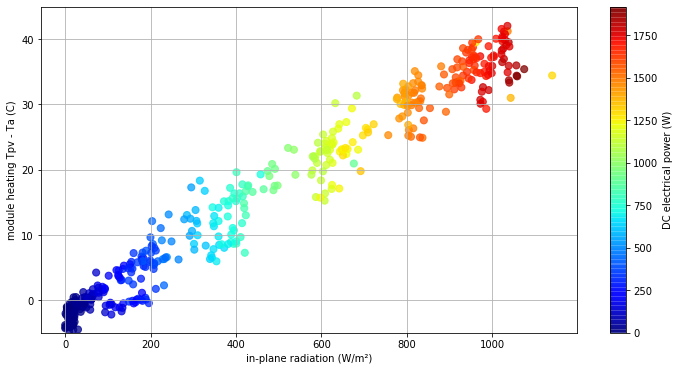

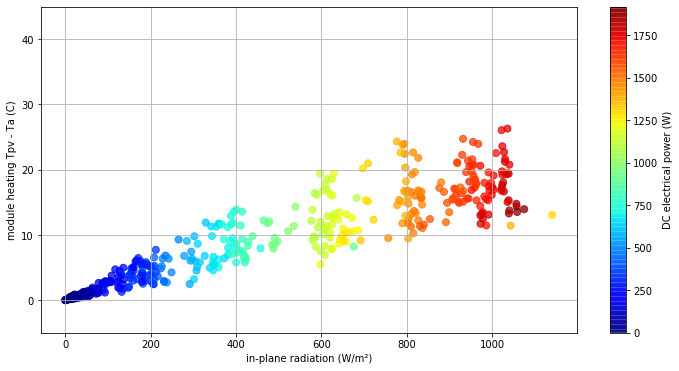

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), facecolor='w')
fig.canvas.set_window_title("scatter plot")
plt.scatter(dataset['_Gi avg [W/m2]'], dataset['Tpv mean'] - dataset['_Tex avg [C]'], s=50,c=dataset['Pdc'],cmap='jet',alpha=0.75)
plt.ylim(-5,45)
plt.xlabel("in-plane radiation (W/m²)")
plt.ylabel("module heating Tpv - Ta (C)")
plt.grid()
cb = plt.colorbar()
cb.set_label("DC electrical power (W)")

fig, ax = plt.subplots(1, 1, figsize=(12, 6), facecolor='w')
fig.canvas.set_window_title("scatter plot")
plt.scatter(dataset['_Gi avg [W/m2]'], dataset['NOCT [C]'] - dataset['_Tex avg [C]'], s=50,c=dataset['Pdc'],cmap='jet',alpha=0.75)
plt.ylim(-5,45)
plt.xlabel("in-plane radiation (W/m²)")
plt.ylabel("module heating Tpv - Ta (C)")
plt.grid()
cb = plt.colorbar()
cb.set_label("DC electrical power (W)")


The scatter plot indicates that the difference between array and ambient temperatures do follow an approximately linear dependence on incident radiation. However the heating significant exceeds NOCT expectations, and the installation underperforms relative to a well-ventilated ground-mounted PV system. This is a feature of building integrated pv (BIPV) systems, and the specific degree of heating depends on the thermal coupling to the building and impact of the local environment. The array temperture and hence loss factor can be predicted providing a sufficiently accurate physical model.

## Outlook
This tutorial has presented a preliminary introduction to PV monitoring analysis. We have looked at how to present PV monitoring data and combine weather data sources using python, what measures are typically used to asses PV systems performance, and we have made a brief inspection of some sample BIPV data.

The reader is invited to use the sample data to look for relationships to explain the variations in system performance. In particular, the student may wish to investigate 
* what are the possible causes for the outliers?
* what is the likely cause low performance for the worst days?


## Final word
I hope you have found this tutorial useful. If you like this format and would be interested to learn more, follow our blog, starting in November 2020! (Contact me for details)

Heliocity is recruting data scientists and software engineers (full stack developpers) in 2021.
leon.gaillard@heliocity.io

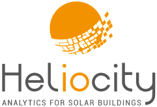